# Description

It selects a set of specific gene pairs from a tissue, and checks if relationship are replicated on other tissues.
It also uses GTEx metadata (such as sex) to explain relationships.

# Modules

In [1]:
from pathlib import Path

import pandas as pd

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from ccc import conf
from ccc.coef import ccc

# Settings

In [2]:
# this gene pair was originally found with ccc on whole blood
# interesting: https://clincancerres.aacrjournals.org/content/26/21/5567.figures-only
# gene0_id, gene1_id = "ENSG00000148153.13", "ENSG00000125812.15"
# gene0_symbol, gene1_symbol = "CYTIP", "RASSF2"

# Paths

In [3]:
# BASE_DIR = Path("/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu/base/gtex")

In [4]:
# TISSUE_DIR = BASE_DIR / "data_by_tissue"
# assert TISSUE_DIR.exists()

BASE_DIR = Path("/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu/base/gtex")
TISSUE_DIR = BASE_DIR / "data_by_tissue"
assert TISSUE_DIR.exists()

In [5]:
MANUSCRIPT_DIR = Path("/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript")
FIGURES_DIR = MANUSCRIPT_DIR / "content" / "images"
OUTPUT_FIGURE_DIR = (
    FIGURES_DIR
    / "gene_pairs"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs')

# Data

## GTEx metadata

In [6]:
gtex_metadata = pd.read_pickle(BASE_DIR / "gtex_v8-sample_metadata.pkl")

In [7]:
gtex_metadata.shape

(22951, 66)

In [8]:
gtex_metadata.head()

,SUBJID,SEX,AGE,DTHHRDY,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gene Ensembl ID -> Symbol mapping

In [9]:
gene_map = pd.read_pickle(BASE_DIR / "gtex_gene_id_symbol_mappings.pkl")

In [10]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [11]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

## Gene pair intersections

In [14]:
gene_pairs = pd.read_pickle(BASE_DIR / "gene_pair_intersections" / "gene_pair_intersections-gtex_v8-whole_blood-var_pc_log2.pkl")

In [15]:
gene_pairs.shape

(1420258456, 9)

In [16]:
gene_pairs.head()

Pearson (high)  Pearson (low)  \
ENSG00000135245.9  ENSG00000169429.10            True          False   
ENSG00000163631.16 ENSG00000169429.10            True          False   
                   ENSG00000135245.9             True          False   
ENSG00000277632.1  ENSG00000169429.10            True          False   
                   ENSG00000135245.9             True          False   

                                       Spearman (high)  Spearman (low)  \
ENSG00000135245.9  ENSG00000169429.10             True           False   
ENSG00000163631.16 ENSG00000169429.10             True           False   
                   ENSG00000135245.9              True           False   
ENSG00000277632.1  ENSG00000169429.10             True           False   
                   ENSG00000135245.9              True           False   

                                       Clustermatch (high)  \
ENSG00000135245.9  ENSG00000169429.10                 True   
ENSG00000163631.16 ENSG00000169429.10                 True   
                   ENSG00000135245.9                  True   
ENSG00000277632.1  ENSG00000169429.10                 True   
                   ENSG00000135245.9                  True   

                                       Clustermatch (low)       ccc   pearson  \
ENSG00000135245.9  ENSG00000169429.10               False  0.780273  0.571777   
ENSG00000163631.16 ENSG00000169429.10               False  0.401611  0.126953   
                   ENSG00000135245.9                False  0.429199  0.110596   
ENSG00000277632.1  ENSG00000169429.10               False  0.789551  0.456543   
                   ENSG00000135245.9                False  0.780273  0.438965   

                                       spearman  
ENSG00000135245.9  ENSG00000169429.10  0.854004  
ENSG00000163631.16 ENSG00000169429.10  0.709473  
                   ENSG00000135245.9   0.675781  
ENSG00000277632.1  ENSG00000169429.10  0.850586  
                   ENSG00000135245.9   0.834473

## Tissue thresholds

In [24]:
tissue_thres = pd.read_pickle(BASE_DIR / "tissue_thresholds" / "whole_blood-null_coefs_percentiles.pkl")

In [25]:
tissue_thres.shape

(101, 3)

In [29]:
tissue_thres.head(21)

,ccc,pearson,spearman
0.00,0.000000,5.675949e-11,0.000000
0.01,0.000000,2.684966e-04,0.000464
0.02,0.000000,5.366048e-04,0.000928
0.03,0.000000,8.009113e-04,0.001393
0.04,0.000000,1.059906e-03,0.001857
0.05,0.000000,1.312019e-03,0.002321
0.06,0.000000,1.555020e-03,0.002786
0.07,0.000000,1.781134e-03,0.003249
0.08,0.000000,1.982608e-03,0.003714
0.09,0.000000,2.165347e-03,0.004181


In [30]:
tissue_thres.tail(21)

,ccc,pearson,spearman
0.80,0.016572,0.013898,0.047449
0.81,0.017155,0.014295,0.048525
0.82,0.017760,0.014724,0.049642
0.83,0.018395,0.015186,0.050804
0.84,0.019062,0.015690,0.052020
0.85,0.019762,0.016245,0.053295
0.86,0.020502,0.016862,0.054639
0.87,0.021284,0.017556,0.056058
0.88,0.022118,0.018352,0.057561
0.89,0.023009,0.019287,0.059171


# Plot

In [17]:
def get_tissue_file(name):
    """
    Given a part of a tissue name, it returns a file path to the
    expression data for that tissue in GTEx. It fails if more than
    one files are found.

    Args:
        name: a string with the tissue name (or a part of it).

    Returns:
        A Path object pointing to the gene expression file for the
        given tissue.
    """
    tissue_files = []
    for f in TISSUE_DIR.glob("*.pkl"):
        if name in f.name:
            tissue_files.append(f)

    assert len(tissue_files) == 1
    return tissue_files[0]

In [18]:
# testing
_tmp = get_tissue_file("whole_blood")
assert _tmp.exists()

In [19]:
def simplify_tissue_name(tissue_name):
    return f"{tissue_name[0].upper()}{tissue_name[1:].replace('_', ' ')}"

In [20]:
assert simplify_tissue_name("whole_blood") == "Whole blood"
assert simplify_tissue_name("uterus") == "Uterus"

In [21]:
def plot_gene_pair(
    tissue_name, gene0, gene1, hue=None, kind="hex", ylim=None, bins="log"
):
    """
    It plots (joint plot) a gene pair from the given tissue. It saves the plot
    for the manuscript.
    """
    # merge gene expression with metadata
    tissue_file = get_tissue_file(tissue_name)
    tissue_data = pd.read_pickle(tissue_file).T[[gene0, gene1]]
    tissue_data = pd.merge(
        tissue_data,
        gtex_metadata,
        how="inner",
        left_index=True,
        right_index=True,
        validate="one_to_one",
    )
    
    display(f"Full data: {tissue_data.shape}")
    
    if hue is not None:
        tissue_data = tissue_data.dropna(subset=[hue])
        display(f"Full data without NaNs: {tissue_data.shape}")

    # get gene symbols
    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    # compute correlations for this gene pair
    _clustermatch = ccc(tissue_data[gene0], tissue_data[gene1])
    _pearson = pearsonr(tissue_data[gene0], tissue_data[gene1])[0]
    _spearman = spearmanr(tissue_data[gene0], tissue_data[gene1])[0]

    _title = f"{simplify_tissue_name(tissue_name)}\n$c={_clustermatch:.2f}$  $p={_pearson:.2f}$  $s={_spearman:.2f}$"

    other_args = {
        "kind": kind,  # if hue is None else "scatter",
        "rasterized": True,
    }
    # if hue is None:
    #     other_args["bins"] = bins
    # else:
    #     other_args["hue_order"] = ["Male", "Female"]

    with sns.plotting_context("paper", font_scale=1.5):
        p = sns.jointplot(
            data=tissue_data,
            x=gene0,
            y=gene1,
            hue=hue,
            **other_args,
            # ylim=(0, 500),
        )

        if ylim is not None:
            p.ax_joint.set_ylim(ylim)

        gene_x_id = p.ax_joint.get_xlabel()
        gene_x_symbol = gene_map[gene_x_id]
        p.ax_joint.set_xlabel(f"{gene_x_symbol}", fontstyle="italic")

        gene_y_id = p.ax_joint.get_ylabel()
        gene_y_symbol = gene_map[gene_y_id]
        p.ax_joint.set_ylabel(f"{gene_y_symbol}", fontstyle="italic")

        p.fig.suptitle(_title)

        # save
        output_file = (
            OUTPUT_FIGURE_DIR
            / f"gtex_{tissue_name}-{gene_x_symbol}_vs_{gene_y_symbol}.svg"
        )
        display(output_file)

        plt.savefig(
            output_file,
            bbox_inches="tight",
            dpi=300,
            facecolor="white",
        )

    return tissue_data

## RASSF2 / CYTIP

In [22]:
gene0_id, gene1_id = "ENSG00000115165.9  ENSG00000101265.15".split()

'Full data: (755, 68)'

('CYTIP', 'RASSF2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-CYTIP_vs_RASSF2.svg')

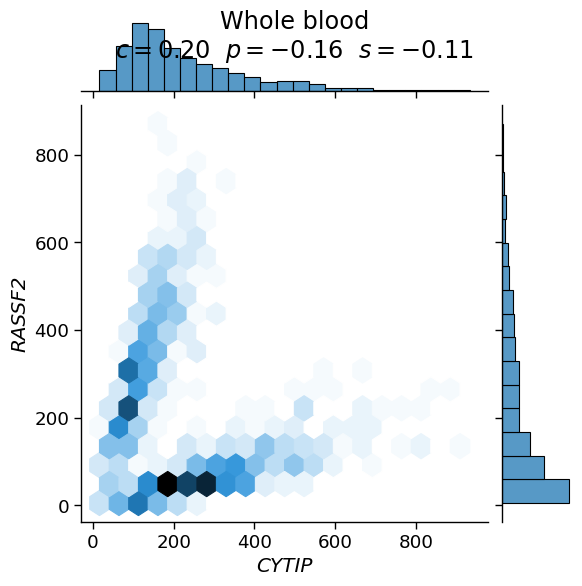

In [23]:
_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

## CCC high, rest low

'Full data: (755, 68)'

('SAMHD1', 'DUSP10')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-SAMHD1_vs_DUSP10.svg')

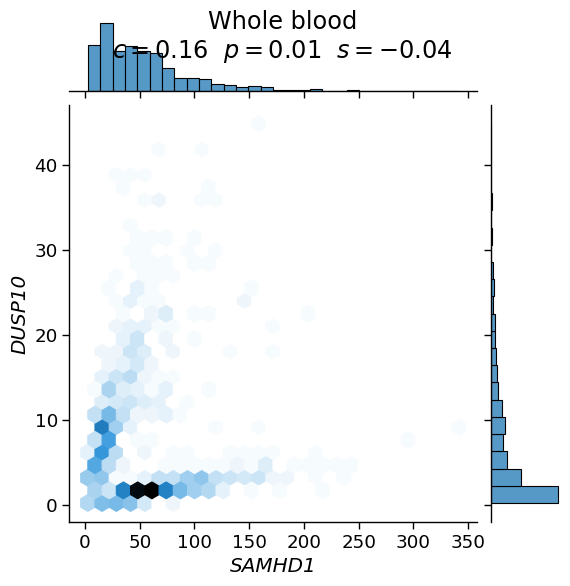

In [44]:
gene0_id, gene1_id = "ENSG00000101347.8  ENSG00000143507.17".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

## Pearson high, CCC low

'Full data: (755, 68)'

('CTD-2201G16.1', 'NEB')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-CTD-2201G16.1_vs_NEB.svg')

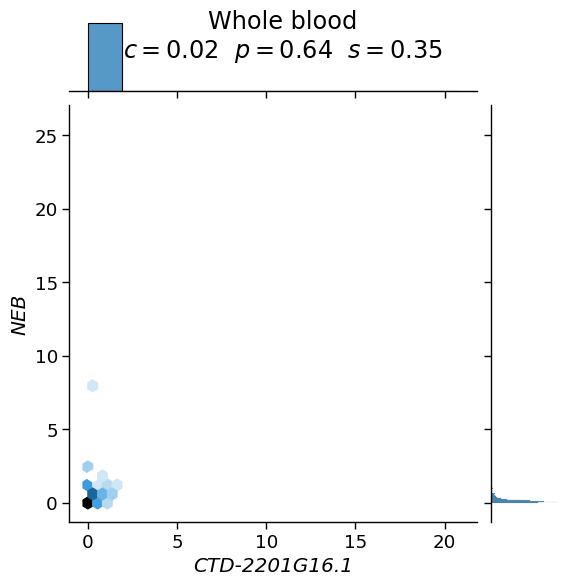

In [20]:
gene0_id, gene1_id = "ENSG00000258444.1 ENSG00000183091.19".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

## In whole blood (where this gene pair was found)

'Full data: (755, 68)'

('FOS', 'IL18R1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-FOS_vs_IL18R1.svg')

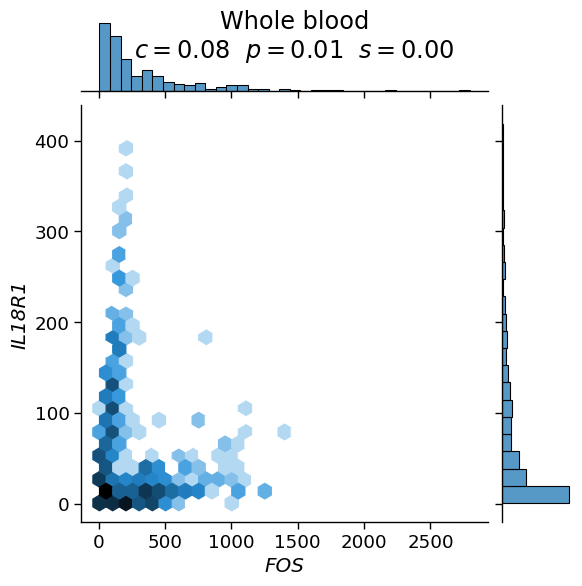

In [79]:
gene0_id, gene1_id = "ENSG00000170345.9  ENSG00000115604.10".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

'Full data: (755, 68)'

('USP28', 'BICD2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-USP28_vs_BICD2.svg')

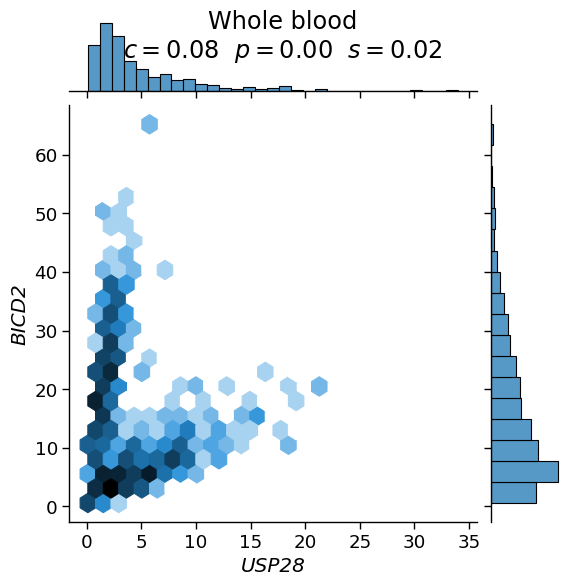

In [78]:
gene0_id, gene1_id = "ENSG00000048028.11 ENSG00000185963.13".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

'Full data: (755, 68)'

('RP11-136I13.1', 'AC012307.2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-RP11-136I13.1_vs_AC012307.2.svg')

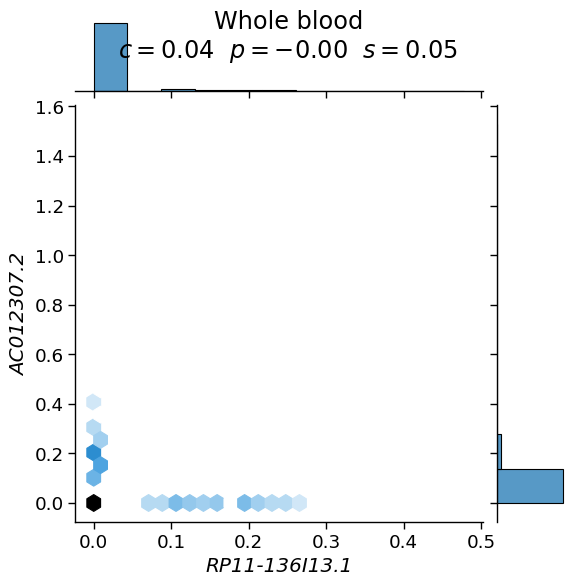

In [65]:
gene0_id, gene1_id = "ENSG00000250613.1  ENSG00000228873.1".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('ASTE1', 'USP28')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-ASTE1_vs_USP28.svg')

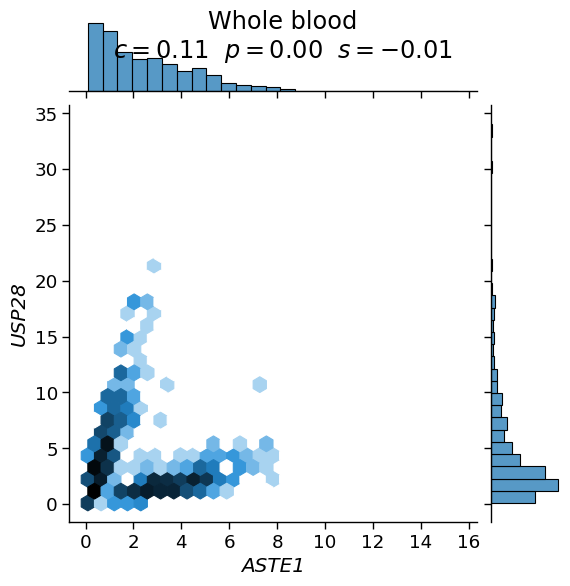

In [60]:
gene0_id, gene1_id = "ENSG00000034533.11 ENSG00000048028.11".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

'Full data: (755, 68)'

('MDC1', 'C9orf69')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-MDC1_vs_C9orf69.svg')

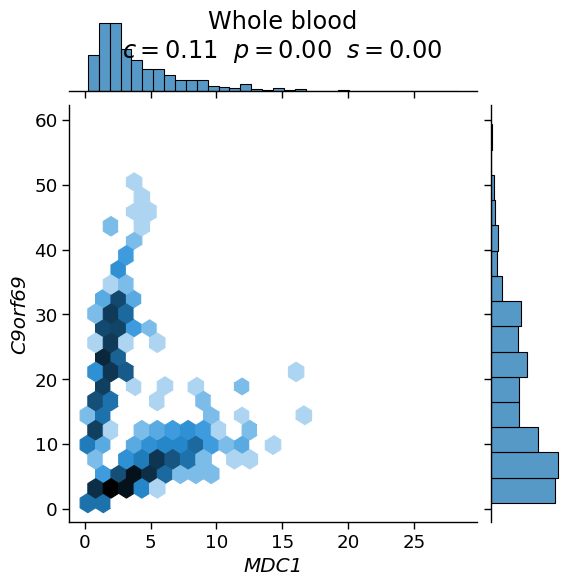

In [57]:
gene0_id, gene1_id = "ENSG00000137337.14 ENSG00000238227.7".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="SEX",
    # kind="scatter",
)

'Full data: (755, 68)'

('CTD-2342N23.1', 'RNA5SP71')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-CTD-2342N23.1_vs_RNA5SP71.svg')

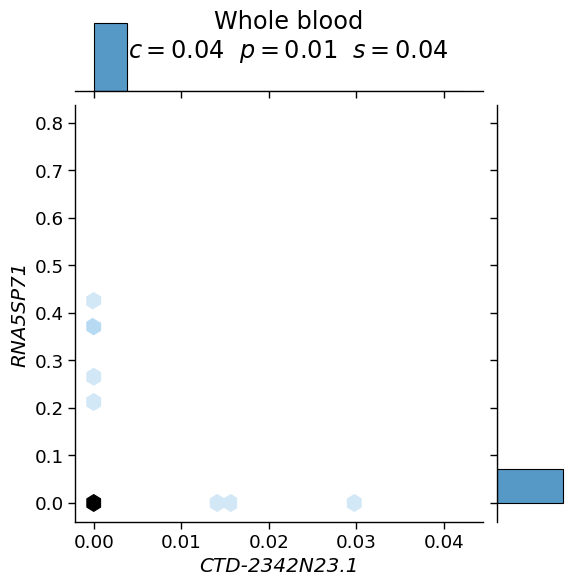

In [51]:
gene0_id, gene1_id = "ENSG00000278898.1 ENSG00000199837.1".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('NREP', 'MAFF')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-NREP_vs_MAFF.svg')

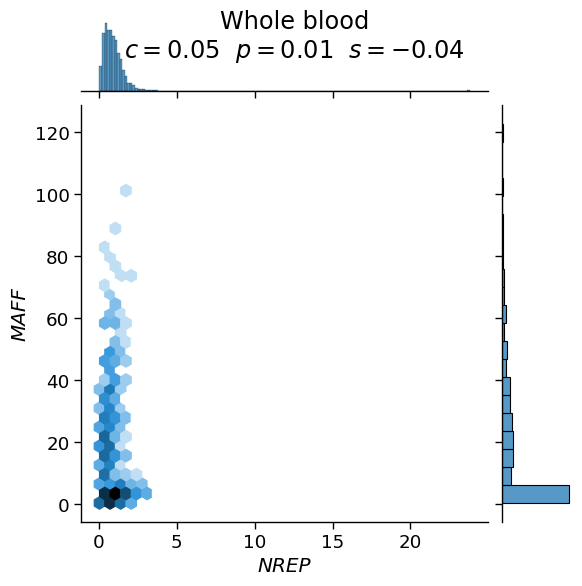

In [50]:
gene0_id, gene1_id = "ENSG00000134986.13 ENSG00000185022.11".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('SUPT20H', 'PPP1R15A')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-SUPT20H_vs_PPP1R15A.svg')

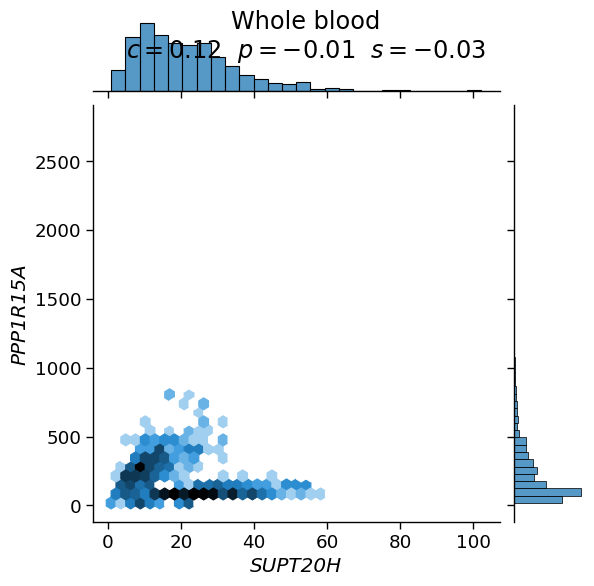

In [45]:
gene0_id, gene1_id = "ENSG00000102710.19 ENSG00000087074.7".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('RP11-51F16.1', 'ARL4C')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-RP11-51F16.1_vs_ARL4C.svg')

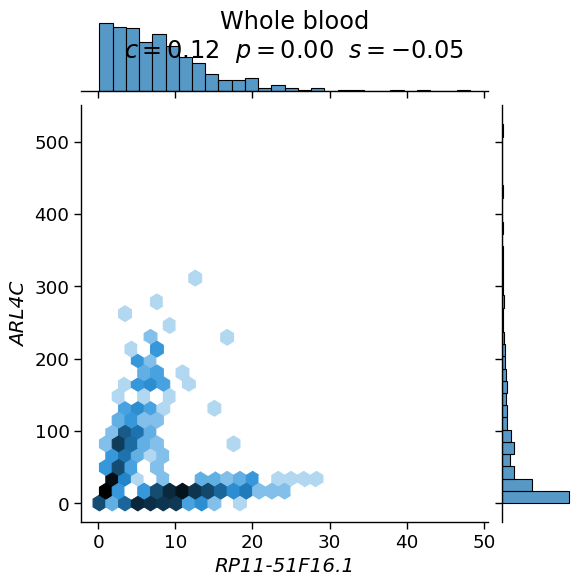

In [44]:
gene0_id, gene1_id = "ENSG00000279369.1  ENSG00000188042.7".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('LACTB2', 'DUSP10')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-LACTB2_vs_DUSP10.svg')

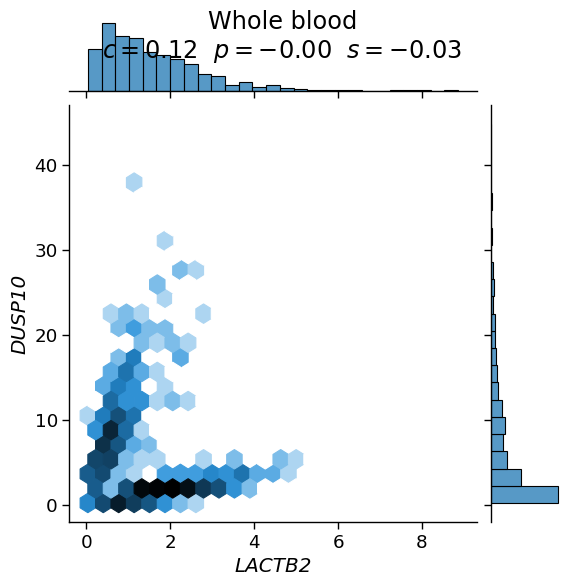

In [43]:
gene0_id, gene1_id = "ENSG00000147592.8  ENSG00000143507.17".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('ZFP36', 'TLR1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-ZFP36_vs_TLR1.svg')

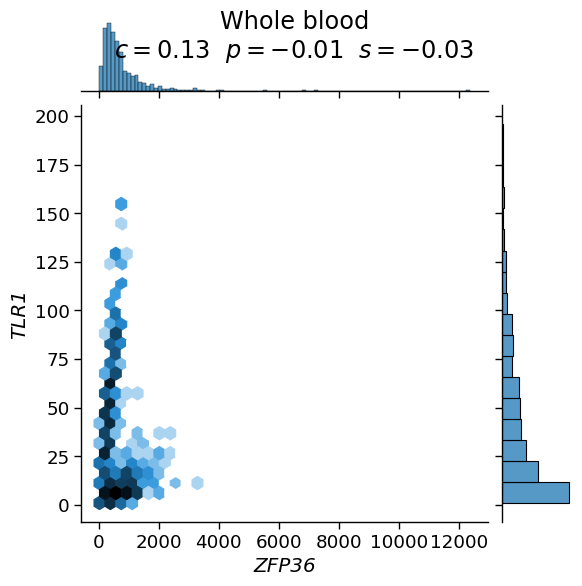

In [42]:
gene0_id, gene1_id = "ENSG00000128016.5  ENSG00000174125.7".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('LINC00846', 'SNORD49A')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-LINC00846_vs_SNORD49A.svg')

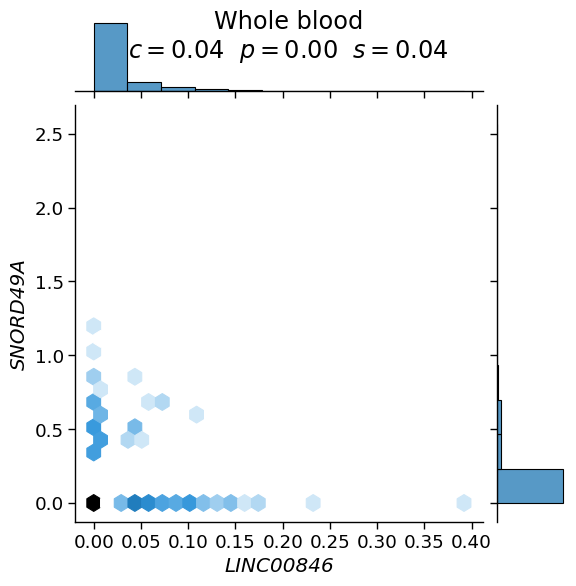

In [41]:
gene0_id, gene1_id = "ENSG00000186842.4  ENSG00000277370.1".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('C5orf58', 'ZBTB18')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-C5orf58_vs_ZBTB18.svg')

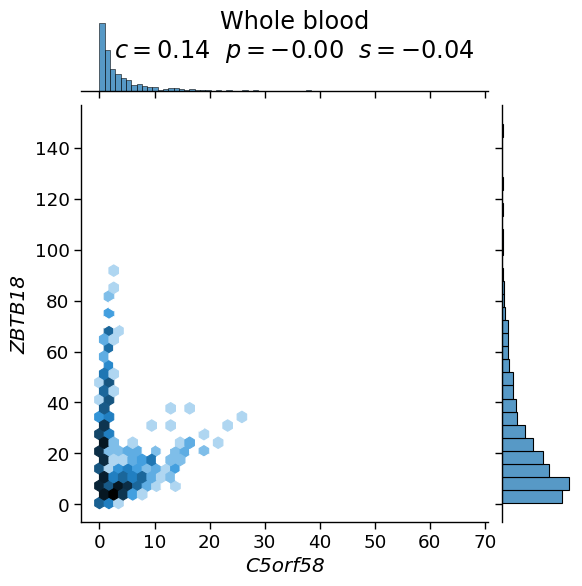

In [40]:
gene0_id, gene1_id = "ENSG00000234511.8  ENSG00000179456.10".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('THAP6', 'GZF1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-THAP6_vs_GZF1.svg')

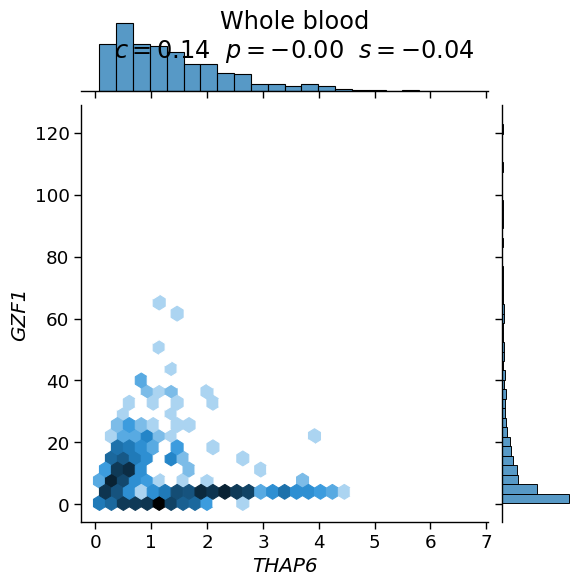

In [39]:
gene0_id, gene1_id = "ENSG00000174796.12 ENSG00000125812.15".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('INIP', 'GZF1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-INIP_vs_GZF1.svg')

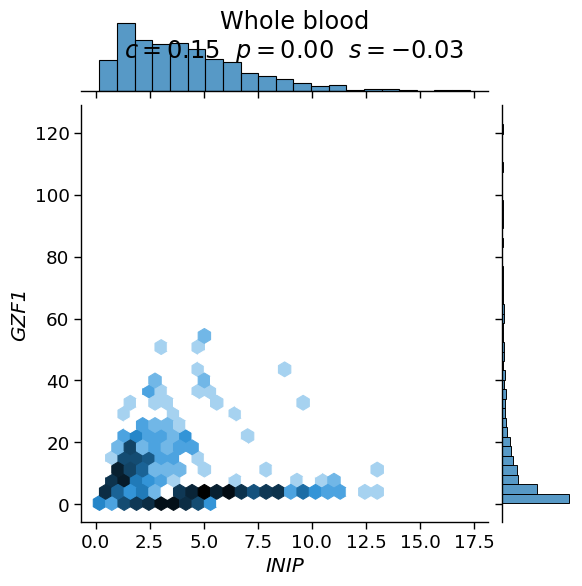

In [38]:
gene0_id, gene1_id = "ENSG00000148153.13 ENSG00000125812.15".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)

'Full data: (755, 68)'

('UTP14C', 'GZF1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-UTP14C_vs_GZF1.svg')

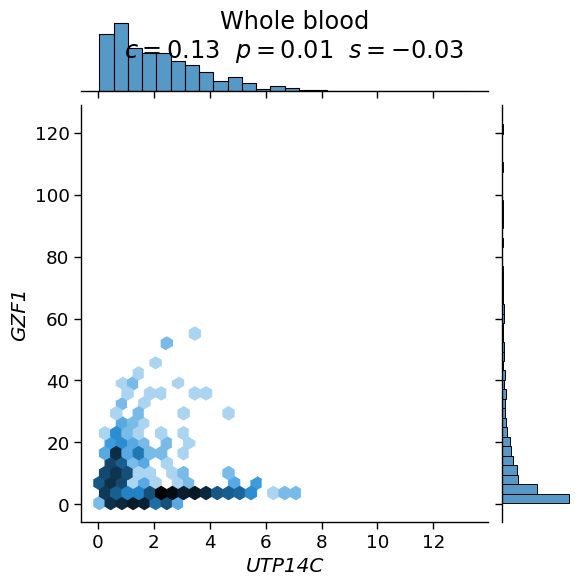

In [37]:
gene0_id, gene1_id = "ENSG00000253797.2  ENSG00000125812.15".split()

_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    # hue="AGE",
    # kind="scatter",
)